# AI4M Mini-Project

## Training a custom generative model: GAN

#### Dataset (100mb sample link) : 

https://artslondon-my.sharepoint.com/:u:/g/personal/l_oconnor0520221_arts_ac_uk/EcFtl6h1_HtIibg_sgVJNuEBaS4uXLXidUeL7lsX3Y9IqA?e=3vk6MT 

See within the notebook for the full dataset in use.

### Description of Process
##### Aims discussed:

When I came to do my final exhibition project in my Fine Art undergraduate degree, I researched this field without any real knowledge of what what really going on in the computing side of things. Looking back on a site like this now, I completely understand the imposed process of the AI in play. 

It was features like this from style gan: > https://medium.com/geekculture/train-a-gan-and-keep-both-your-kidneys-bcf672e94e81
that I was interested in to research the AI field at the time.

I essentially created something of a similar liking as the GIF displayed on this site, but I completing the task I set for myself by taking a satelite image and manipulating the pixels microscopically a couple hundred times manually.

I much as I would like to produce a dataset of large-scale dataset of remote sensing imagery, though I found a couple contingencies with this early such as within the translation of co-codinates on the globe to a cartesian grid. For example, features closer to the equator appear much smaller than their true representational size. It would force a model to learn a wider output distribution and increasing the likelihood of overfitting - Perhaps one to save for a bigger project.

#### Using a downloaded set of aerial images introduces a linear structure to the set as they are all aerial view. With the 566 of images that I have and computational power, I will train the model in a couple of ways given the time frame I have also.

#### Basing off of code from a previous class notebook, I will adapt it to see how a DCGAN works and how I can use it to my advantage with the dataset I have created. DCGAN is relatively simple in the hierachy of GAN networks - batter than a Vanilla GAN and not up to speed with the likes of a StyleGAN. I want to see how well it can adapt to my dataset and how many training epochs this might take to train such a network.

# Training a DCGAN
#### Deep Convolutional GAN

In [2]:
!pip install gdown

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import gdown
from zipfile import ZipFile

### Inputing the dataset. This is 566 images of aerial landscapes.

In [16]:
DATASET_DIR = r'C:\Users\luoco\Desktop\AI4M_assignment_1_dataset_versions\AI4M_dataset-lucy-oconnor'
OUTPUT_DIR = r'C:\Users\luoco\Desktop\AI4M_assignment_1_dataset_versions'
try:
  os.makedirs(DATASET_DIR)
  os.makedirs(OUTPUT_DIR)
except:
  pass

# url = "https://drive.google.com/drive/folders/1z_RQWoCHG5cpWJuiZOyDM6AdYnrKtILf"
# output = f"{DATASET_DIR}/data.zip"
# gdown.download(url, output, quiet=False)

# with ZipFile(f"{DATASET_DIR}/data.zip", "r") as zipobj:
   # zipobj.extractall(f"{DATASET_DIR}")

##### Using the Keras image_dataset_from_directory to turn our folder full of images into a Tensorflow dataset which makes loading images from the dataset much more efficient during training.

In [17]:
dataset = keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    label_mode=None,
    image_size=(64, 64),   # adapted to 512 to match automatic resize using dataset tools
    batch_size=32,
    seed=999,
    validation_split=0.95, # Spliting the dataset 1:9 (training:validation) just to make it smaller!
    subset='training' # Taking the smaller 'validation' set.
)
dataset = dataset.map(lambda x: x / 255.0)

Found 566 files belonging to 1 classes.
Using 29 files for training.


##### See some examples it captures! They are a very low and pixelated quality, I'll experiment further later on.

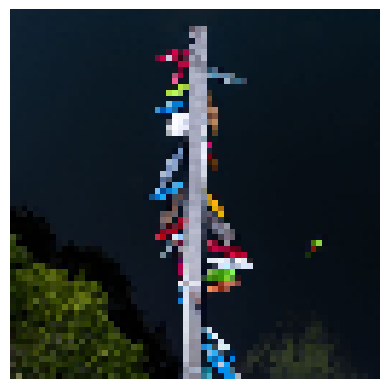

In [18]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

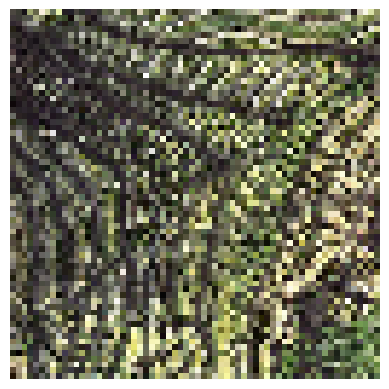

In [19]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

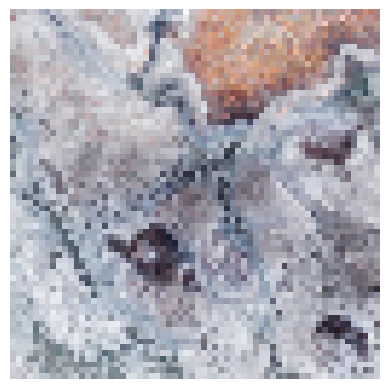

In [20]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

#### Defining the discriminator

In [21]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),                 #here is where the leakyRELU gets flattened then sent to final fully connected layer.
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()


Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 8192)            

##### Defining the Generator


Notes:
- Final layer is a regular 2D convolution has only 3 filters which gives us an RGB image as output.
- It is the combination of the kernel size of 4 and the stride of 2 which doubles the size each layer from 8x8 to 16x16 to 32x32 to the final size of 64x64.

In [22]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                                       
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 32, 32, 256)       0 

##### Defining the GAN

In [23]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

Calling the function below when certain conditions are met - whenever an epoch of training is complete. This saves an image to folder and observes the output of the generator.

In [24]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save(os.path.join(OUTPUT_DIR, "generated_img_%03d_%d.png" % (epoch, i)))


#### GAN TRAINING

In [25]:
epochs = 2  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/2
1/1 [==============================] - 6s 6s/step - d_loss: 0.6912 - g_loss: 0.7596
Epoch 2/2
1/1 [==============================] - 5s 5s/step - d_loss: 0.6846 - g_loss: 0.7889


##### Check an output

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


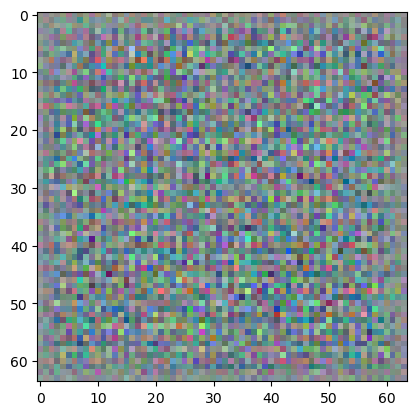

In [26]:
%pylab inline
import matplotlib.image as mpimg
img = mpimg.imread(r'C:\Users\luoco\Desktop\AI4M_assignment_1_dataset_versions\generated_img_000_0.png')
imgplot = plt.imshow(img)
plt.show()

##### Check multiple generated outputs

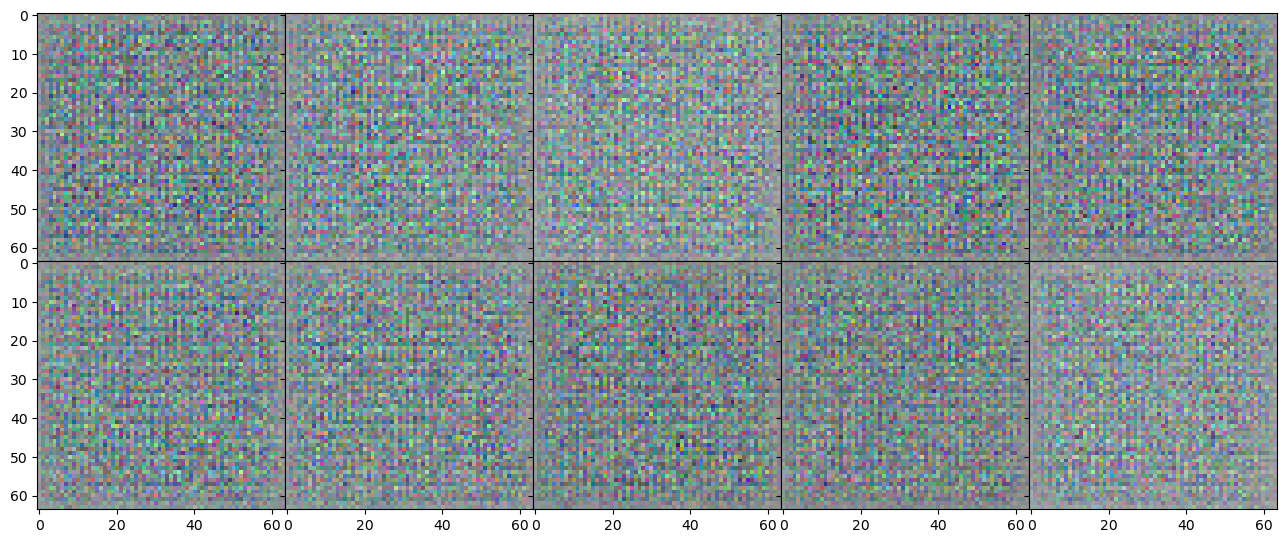

In [32]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(16., 16.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 5),  # creates 5x2 grid of axes
                 axes_pad=0,  # pad between axes in inch.
                 )

#root_path = r'C:\Users\luoco\Desktop\AI4M_assignment_1_dataset_versions\generated_img_00'
#images = root_path + str(i) + '_0.png'

# ^^^above is another way to define images and find them once generated.

images = [f"C:/Users/luoco/Desktop/AI4M_assignment_1_dataset_versions/generated_img_000_{x}.png" for x in range(10)]

##00{x}_0.png  ->   backend of the image file wasn't correctly formatted to how it saved!

for ax, im in zip(grid, images):
    # Iterating over the grid returns the Axes.
    img = mpimg.imread(im)
    ax.imshow(img)

plt.show()

I'm impressed with the vast amount of colouring it has captured given only a portion of the training set. Very much like the start up of an old school television! Though understandably, there is little to no variation between the outputs generated. One evident aspect I notice is the saturation of the images, some appear lighter/ darker than others.


# TRAINING with a full dataset
The following resolution uses 64*64 pixel images. This will run through a cycle of 100 epochs, which is a much better amount that is likely to be used in practice.

In [60]:
DATASET_DIR = r'C:\Users\luoco\Desktop\AI4M_assignment_1_dataset_versions\AI4M_dataset-lucy-oconnor'
OUTPUT_DIR = r'C:\Users\luoco\Desktop\AI4M_assignment_1_dataset_versions'
try:
  os.makedirs(DATASET_DIR)
  os.makedirs(OUTPUT_DIR)
except:
  pass

In [61]:
dataset = keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    label_mode=None,
    image_size=(64, 64),   # can be adapted for resolution.
    batch_size=32,
     # using the full dataset
)
dataset = dataset.map(lambda x: x / 255.0)

Found 566 files belonging to 1 classes.


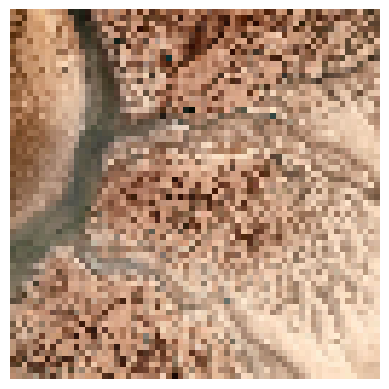

In [62]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

In [63]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),   #here is where the leakyRELU gets flattened then sent to final fully connected layer.
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()


Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_26 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 flatten_4 (Flatten)         (None, 8192)            

In [64]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape_4 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_12 (Conv2D  (None, 16, 16, 128)      262272    
 Transpose)                                                      
                                                                 
 leaky_re_lu_27 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_13 (Conv2D  (None, 32, 32, 256)      524544    
 Transpose)                                                      
                                                                 
 leaky_re_lu_28 (LeakyReLU)  (None, 32, 32, 256)       0 

In [65]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [66]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save(os.path.join(OUTPUT_DIR, "generated_img_%03d_%d.png" % (epoch, i)))


#### 100 Epochs in practice.

In [67]:
epochs = 100  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/100
18/18 [==============================] - 96s 5s/step - d_loss: 0.6695 - g_loss: 0.8328
Epoch 2/100
18/18 [==============================] - 102s 6s/step - d_loss: 0.5104 - g_loss: 0.8923
Epoch 3/100
18/18 [==============================] - 108s 6s/step - d_loss: 0.6915 - g_loss: 1.0349
Epoch 4/100
18/18 [==============================] - 106s 6s/step - d_loss: 0.7960 - g_loss: 1.0018
Epoch 5/100
18/18 [==============================] - 109s 6s/step - d_loss: 0.0879 - g_loss: 3.9217
Epoch 6/100
18/18 [==============================] - 138s 8s/step - d_loss: 0.4650 - g_loss: 2.4755
Epoch 7/100
18/18 [==============================] - 153s 8s/step - d_loss: 0.7942 - g_loss: 0.9744
Epoch 8/100
18/18 [==============================] - 159s 9s/step - d_loss: 0.9283 - g_loss: 0.6982
Epoch 9/100
18/18 [==============================] - 153s 8s/step - d_loss: 0.5424 - g_loss: 1.0495
Epoch 10/100
18/18 [==============================] - 148s 8s/step - d_loss: 0.3704 - g_loss: 1.8744


18/18 [==============================] - 104s 6s/step - d_loss: 0.0945 - g_loss: 3.8799
Epoch 83/100
18/18 [==============================] - 106s 6s/step - d_loss: 0.1142 - g_loss: 3.2217
Epoch 84/100
18/18 [==============================] - 106s 6s/step - d_loss: 0.1634 - g_loss: 2.5675
Epoch 85/100
18/18 [==============================] - 107s 6s/step - d_loss: 0.4268 - g_loss: 1.9581
Epoch 86/100
18/18 [==============================] - 109s 6s/step - d_loss: 1.2426 - g_loss: 1.0064
Epoch 87/100
18/18 [==============================] - 106s 6s/step - d_loss: 0.1680 - g_loss: 2.9741
Epoch 88/100
18/18 [==============================] - 107s 6s/step - d_loss: 0.3283 - g_loss: 1.8023
Epoch 89/100
18/18 [==============================] - 108s 6s/step - d_loss: 0.8346 - g_loss: 1.7624
Epoch 90/100
18/18 [==============================] - 108s 6s/step - d_loss: 1.1066 - g_loss: 1.3153
Epoch 91/100
18/18 [==============================] - 107s 6s/step - d_loss: 0.4270 - g_loss: 1.6986
Epo

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


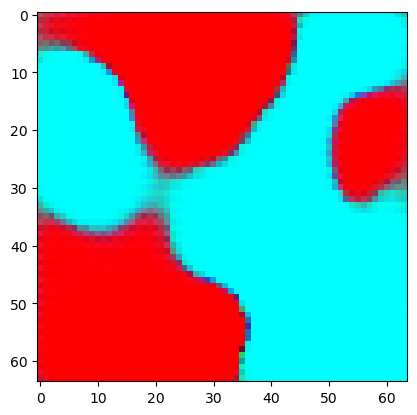

In [69]:
# look at some of these!
%pylab inline
import matplotlib.image as mpimg
img = mpimg.imread(r'C:\Users\luoco\Desktop\AI4M_assignment_1_dataset_versions\generated_img_059_5.png')
imgplot = plt.imshow(img)
plt.show()

#### Love this one above! Very cartoon like with the colours it's captured.

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


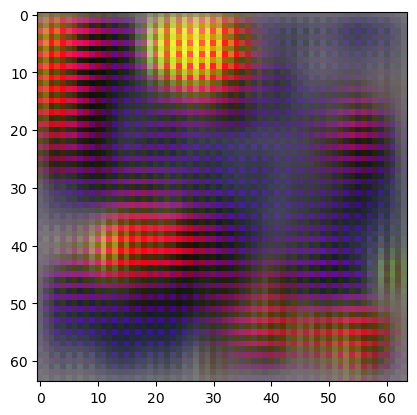

In [70]:
%pylab inline
import matplotlib.image as mpimg
img = mpimg.imread(r'C:\Users\luoco\Desktop\AI4M_assignment_1_dataset_versions\generated_img_098_8.png')
imgplot = plt.imshow(img)
plt.show()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


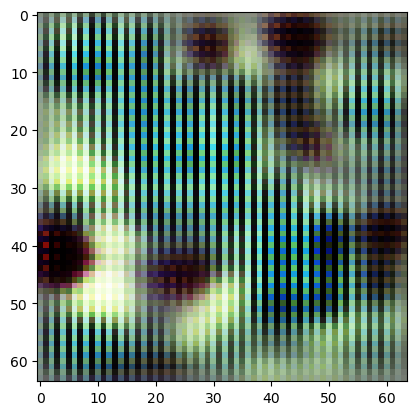

In [74]:
%pylab inline
import matplotlib.image as mpimg
img = mpimg.imread(r'C:\Users\luoco\Desktop\AI4M_assignment_1_dataset_versions\generated_img_085_4.png')
imgplot = plt.imshow(img)
plt.show()

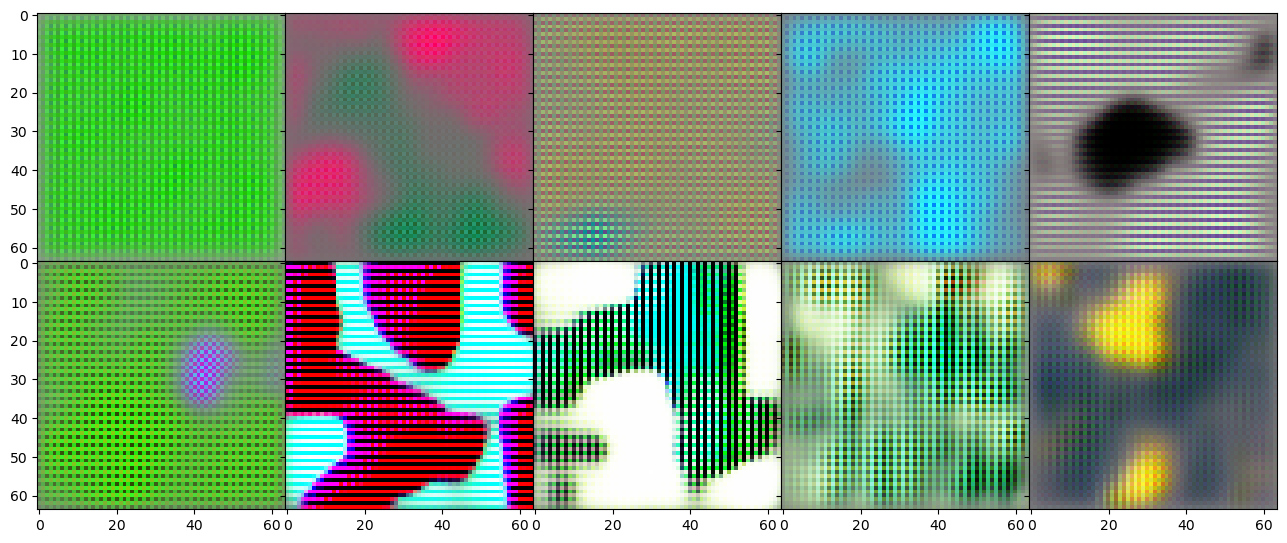

In [73]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(16., 16.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 5),  # creates 5x2 grid of axes
                 axes_pad=0,  # pad between axes in inch.
                 )

images = [f"C:/Users/luoco/Desktop/AI4M_assignment_1_dataset_versions/generated_img_0{x}{x}_{x}.png" for x in range(10)]

for ax, im in zip(grid, images):
    # Iterating over the grid returns the Axes.
    img = mpimg.imread(im)
    ax.imshow(img)

plt.show()

#000_{x}.png

There's definitely a thought process going on to define things like land against sea, or objects on land. There's quality differentiation beginning to split features! Even though it has only begun training, it's creating some lovely abstract forms. 
I didn't expect the results to generate such colourful iterations of images!

# TRAINING with a full dataset
### Up the resolution! Now 128*128
I will adapt the next round of GAN training. 
- Started at resolution of 64 > 128, > 256, > 512 (resolution of images in dataset)


In [163]:
DATASET_DIR = r'C:\Users\luoco\Desktop\AI4M_assignment_1_dataset_versions\AI4M_dataset-lucy-oconnor'
OUTPUT_DIR = r'C:\Users\luoco\Desktop\AI4M_assignment_1_dataset_versions'
try:
  os.makedirs(DATASET_DIR)
  os.makedirs(OUTPUT_DIR)
except:
  pass

In [164]:
dataset = keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    label_mode=None,
    image_size=(128, 128), #adapted here for resolution
    batch_size=32,
)
dataset = dataset.map(lambda x: x / 255.0)

Found 566 files belonging to 1 classes.


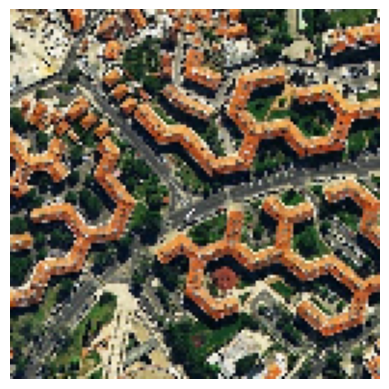

In [165]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

In [173]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(128, 128, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"), #EXTRA LAYERS HERE to be compatible with the higher resolution.
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),             #here is where the leakyRELU gets flattened then sent to final fully connected layer.
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()


Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_80 (Conv2D)          (None, 64, 64, 64)        3136      
                                                                 
 leaky_re_lu_125 (LeakyReLU)  (None, 64, 64, 64)       0         
                                                                 
 conv2d_81 (Conv2D)          (None, 32, 32, 128)       131200    
                                                                 
 leaky_re_lu_126 (LeakyReLU)  (None, 32, 32, 128)      0         
                                                                 
 conv2d_82 (Conv2D)          (None, 16, 16, 128)       262272    
                                                                 
 leaky_re_lu_127 (LeakyReLU)  (None, 16, 16, 128)      0         
                                                                 
 conv2d_83 (Conv2D)          (None, 8, 8, 128)       

In [174]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),   #EXTRA LAYER ADDED 
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 8192)              1056768   
                                                                 
 reshape_22 (Reshape)        (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_67 (Conv2D  (None, 16, 16, 128)      262272    
 Transpose)                                                      
                                                                 
 leaky_re_lu_129 (LeakyReLU)  (None, 16, 16, 128)      0         
                                                                 
 conv2d_transpose_68 (Conv2D  (None, 32, 32, 256)      524544    
 Transpose)                                                      
                                                                 
 leaky_re_lu_130 (LeakyReLU)  (None, 32, 32, 256)      0 

In [175]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [176]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save(os.path.join(OUTPUT_DIR, "generated_img_%03d_%d.png" % (epoch, i)))


In [177]:
epochs = 100  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/100
18/18 [==============================] - 929s 52s/step - d_loss: 0.6652 - g_loss: 0.8319
Epoch 2/100
18/18 [==============================] - 794s 43s/step - d_loss: 0.4964 - g_loss: 0.9807
Epoch 3/100
18/18 [==============================] - 921s 51s/step - d_loss: 0.7425 - g_loss: 1.0513
Epoch 4/100
18/18 [==============================] - 848s 46s/step - d_loss: 0.1264 - g_loss: 3.3039
Epoch 5/100
18/18 [==============================] - 855s 47s/step - d_loss: 0.0898 - g_loss: 8.6515
Epoch 6/100
18/18 [==============================] - 857s 47s/step - d_loss: 1.9724 - g_loss: 0.8265
Epoch 7/100
18/18 [==============================] - 798s 44s/step - d_loss: 0.3101 - g_loss: 2.1559
Epoch 8/100
18/18 [==============================] - 849s 47s/step - d_loss: 1.4616 - g_loss: 0.5059
Epoch 9/100
18/18 [==============================] - 880s 48s/step - d_loss: 0.5704 - g_loss: 0.8600
Epoch 10/100
18/18 [==============================] - 853s 47s/step - d_loss: 0.4397 - g_lo

##### This took a working time over a 3 day period. Though I believe it didn't run as efficiently overnight.

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


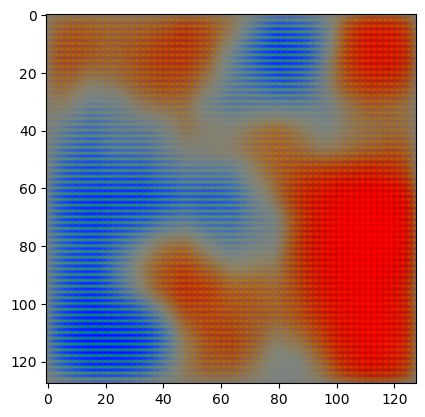

In [179]:
# look at some of these!
%pylab inline
import matplotlib.image as mpimg
img = mpimg.imread(r'C:\Users\luoco\Desktop\AI4M_assignment_1_dataset_versions\generated_img_039_3.png')
imgplot = plt.imshow(img)
plt.show()

Just for reference, seeing if the files are generating the same or not. Below is the same file number as the previous trial.

Once the training and generation was completed. I took the generated files and stored them away in a new folder and re-run the generation.

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


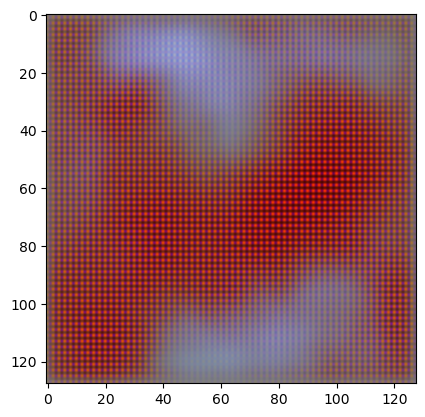

In [180]:
# look at some of these!
%pylab inline
import matplotlib.image as mpimg
img = mpimg.imread(r'C:\Users\luoco\Desktop\AI4M_assignment_1_dataset_versions\generated_img_085_4.png')  #saem number as previous trial
imgplot = plt.imshow(img)
plt.show()

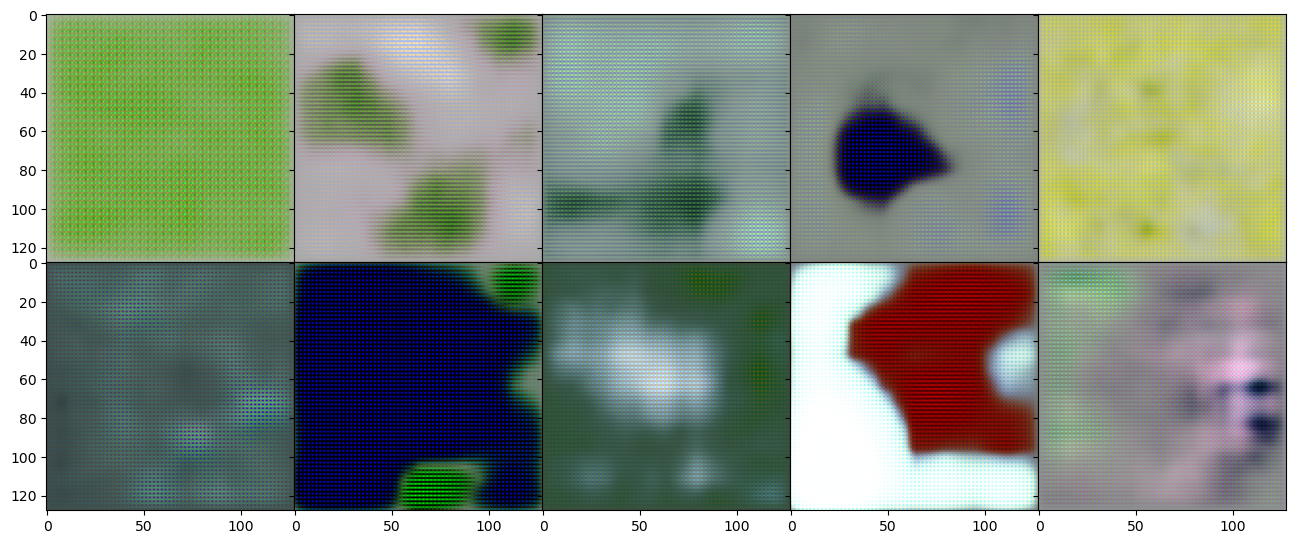

In [182]:
fig = plt.figure(figsize=(16., 16.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 5),  # creates 5x2 grid of axes
                 axes_pad=0,  # pad between axes in inch.
                 )

images = [f"C:/Users/luoco/Desktop/AI4M_assignment_1_dataset_versions/generated_img_0{x}{x}_{x}.png" for x in range(10)]

for ax, im in zip(grid, images):
    # Iterating over the grid returns the Axes.
    img = mpimg.imread(im)
    ax.imshow(img)

plt.show()

#000_{x}.png

### Thoughts:
- There's a lot more green taken into this trial. Though the ones which are more colourful are definitely more dramatic than the previous trial. 
- The top right hand corner of the following is starting to show signs of depth in the image.

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


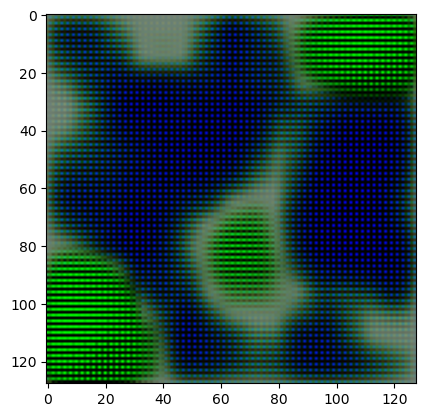

In [183]:
# look at some of these!
%pylab inline
import matplotlib.image as mpimg
img = mpimg.imread(r'C:\Users\luoco\Desktop\AI4M_assignment_1_dataset_versions\generated_img_066_9.png')  #saem number as previous trial
imgplot = plt.imshow(img)
plt.show()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


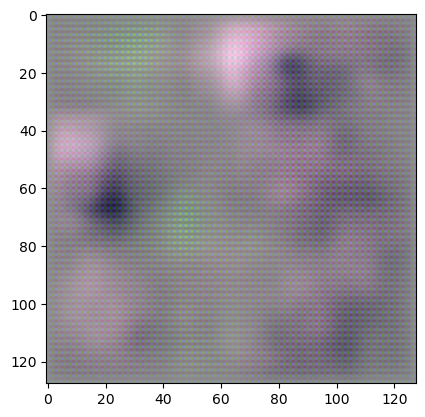

In [184]:
# look at some of these!
%pylab inline
import matplotlib.image as mpimg
img = mpimg.imread(r'C:\Users\luoco\Desktop\AI4M_assignment_1_dataset_versions\generated_img_099_5.png')  #saem number as previous trial
imgplot = plt.imshow(img)
plt.show()

The one above has a real likeness towards a mountain range. You can really see some depth and heights in the image.

# TRAINING the full dataset 
## Back to 64 - run time of the 128*128 worked across a 3 day period
#### Will experiment with 64*64 resolution.

Given the time it took on the 128 run, I will experiment further with the 64*64 images. 

Even though the images are very pixelated, it would be great to see some outlining of different shapes and colours as opposed to a 2 colour formation.

### I will add in Batch Normalization. (Specified in the code)
Few things noted for using Batch Normalization: 
- a technique to normalize activations in intermediate layers of deep neural networks
- tendency to improve accuracy 
- speed up training/ use a higher learning rate
- has a regularizing effect which means you can often remove dropout layer

In [1]:
#kernel died, reimporting things needed.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import gdown
from zipfile import ZipFile

In [2]:
DATASET_DIR = r'C:\Users\luoco\Desktop\AI4M_assignment_1_dataset_versions\AI4M_dataset-lucy-oconnor'
OUTPUT_DIR = r'C:\Users\luoco\Desktop\AI4M_assignment_1_dataset_versions'
try:
  os.makedirs(DATASET_DIR)
  os.makedirs(OUTPUT_DIR)
except:
  pass

In [3]:
dataset = keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    label_mode=None,
    image_size=(64, 64),
    batch_size=32,
     # using the full dataset
)
dataset = dataset.map(lambda x: x / 255.0)

Found 566 files belonging to 1 classes.


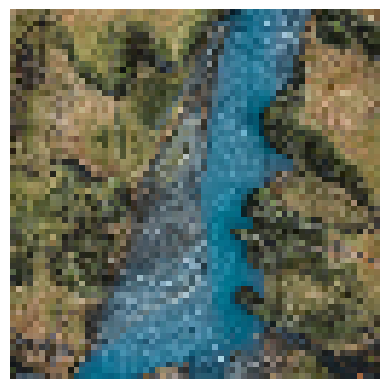

In [6]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

In [7]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),             #here is where the leakyRELU gets flattened then sent to final fully connected layer.
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)            

In [12]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        keras.layers.BatchNormalization(),                                      #BATCH NORMALIZATION ADDED
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        keras.layers.BatchNormalization(),                                      #BATCH NORMALIZATION ADDED
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                                       
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 32, 32, 256)       0 

In [13]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [18]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save(os.path.join(OUTPUT_DIR, "generated_img_%03d_%d.png" % (epoch, i)))


In [19]:
epochs = 100  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/100
18/18 [==============================] - 101s 5s/step - d_loss: 0.8215 - g_loss: 0.7902
Epoch 2/100
18/18 [==============================] - 104s 6s/step - d_loss: 0.4671 - g_loss: 1.1698
Epoch 3/100
18/18 [==============================] - 101s 6s/step - d_loss: 0.1442 - g_loss: 3.0448
Epoch 4/100
18/18 [==============================] - 106s 6s/step - d_loss: 0.6546 - g_loss: 2.1430
Epoch 5/100
18/18 [==============================] - 103s 6s/step - d_loss: 0.7495 - g_loss: 1.7866
Epoch 6/100
18/18 [==============================] - 101s 6s/step - d_loss: 1.8120 - g_loss: 0.3859
Epoch 7/100
18/18 [==============================] - 109s 6s/step - d_loss: 0.6445 - g_loss: 1.0112
Epoch 8/100
18/18 [==============================] - 109s 6s/step - d_loss: 0.3003 - g_loss: 1.6995
Epoch 9/100
18/18 [==============================] - 108s 6s/step - d_loss: 0.2968 - g_loss: 2.1006
Epoch 10/100
18/18 [==============================] - 109s 6s/step - d_loss: 1.4414 - g_loss: 0.7622

18/18 [==============================] - 132s 7s/step - d_loss: 0.5929 - g_loss: 1.2920
Epoch 83/100
18/18 [==============================] - 131s 7s/step - d_loss: 0.4251 - g_loss: 1.4617
Epoch 84/100
18/18 [==============================] - 121s 7s/step - d_loss: 0.4814 - g_loss: 1.3488
Epoch 85/100
18/18 [==============================] - 123s 7s/step - d_loss: 0.6133 - g_loss: 1.0648
Epoch 86/100
18/18 [==============================] - 121s 7s/step - d_loss: 0.6454 - g_loss: 1.1370
Epoch 87/100
18/18 [==============================] - 134s 7s/step - d_loss: 0.3762 - g_loss: 1.5819
Epoch 88/100
18/18 [==============================] - 143s 8s/step - d_loss: 1.1132 - g_loss: 0.4461
Epoch 89/100
18/18 [==============================] - 143s 8s/step - d_loss: 0.6265 - g_loss: 0.9767
Epoch 90/100
18/18 [==============================] - 143s 8s/step - d_loss: 1.0781 - g_loss: 0.7877
Epoch 91/100
18/18 [==============================] - 143s 8s/step - d_loss: 0.8619 - g_loss: 1.1734
Epo

### Note: this batch of training took 2-3hours, quickest by far.

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


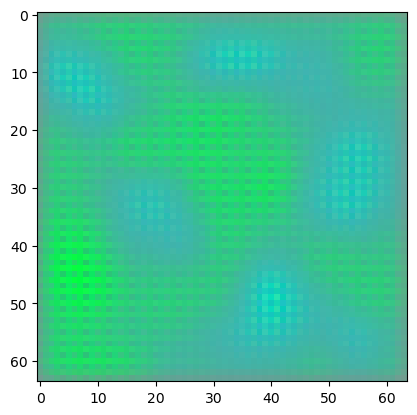

In [21]:
%pylab inline
import matplotlib.image as mpimg
img = mpimg.imread(r'C:\Users\luoco\Desktop\AI4M_assignment_1_dataset_versions\generated_img_009_7.png')
imgplot = plt.imshow(img)
plt.show()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


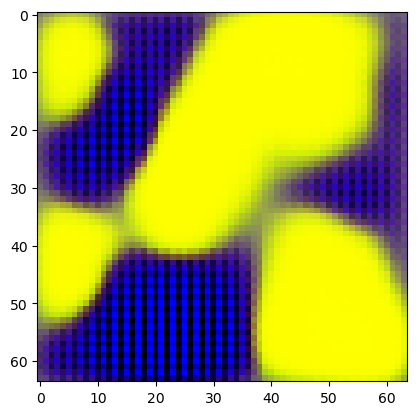

In [22]:
%pylab inline
import matplotlib.image as mpimg
img = mpimg.imread(r'C:\Users\luoco\Desktop\AI4M_assignment_1_dataset_versions\generated_img_050_8.png')
imgplot = plt.imshow(img)
plt.show()

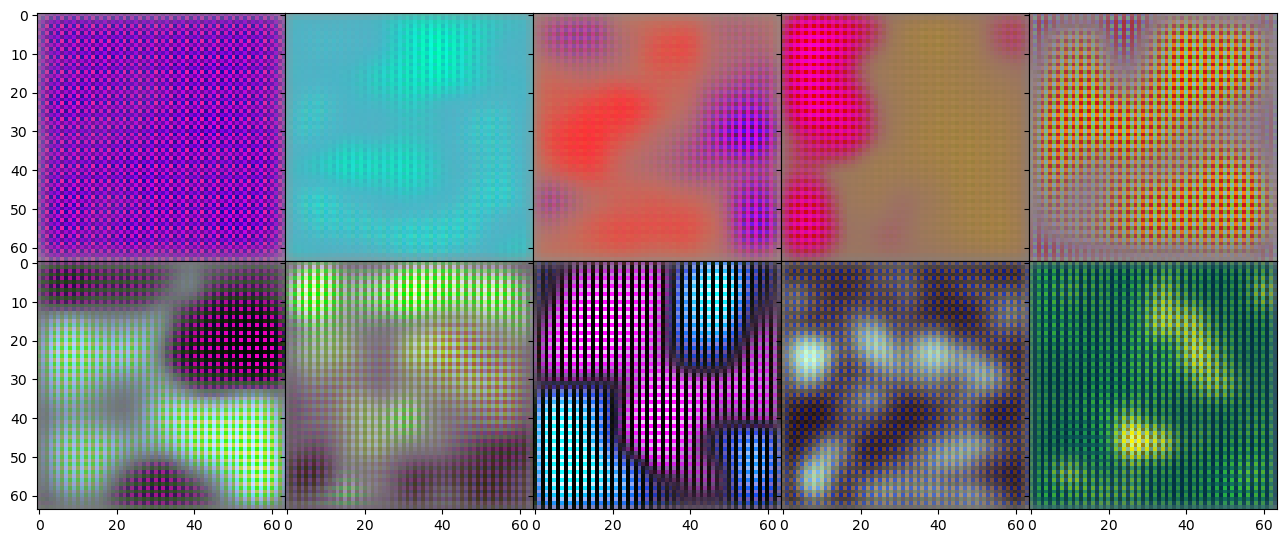

In [24]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(16., 16.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 5),  # creates 5x2 grid of axes
                 axes_pad=0,  # pad between axes in inch.
                 )

images = [f"C:/Users/luoco/Desktop/AI4M_assignment_1_dataset_versions/generated_img_0{x}{x}_{x}.png" for x in range(10)]

for ax, im in zip(grid, images):
    # Iterating over the grid returns the Axes.
    img = mpimg.imread(im)
    ax.imshow(img)

plt.show()

# TRAINING the full dataset
## 64*64, Batch Norm, Many Epochs...
This will be the final trail. I'm curious to see how many epochs I can push, given batch normalisation makes the network more efficient. 

So, as the run before, but more epochs in training. This is definitely not remotely overfitting yet, so I imagine that more epochs will produce better results than any worse depsite 100 being the normal amount for practical purposes.

In [25]:
DATASET_DIR = r'C:\Users\luoco\Desktop\AI4M_assignment_1_dataset_versions\AI4M_dataset-lucy-oconnor'
OUTPUT_DIR = r'C:\Users\luoco\Desktop\AI4M_assignment_1_dataset_versions'
try:
  os.makedirs(DATASET_DIR)
  os.makedirs(OUTPUT_DIR)
except:
  pass

In [26]:
dataset = keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    label_mode=None,
    image_size=(64, 64), 
    batch_size=32,
     # using the full dataset
)
dataset = dataset.map(lambda x: x / 255.0)

Found 566 files belonging to 1 classes.


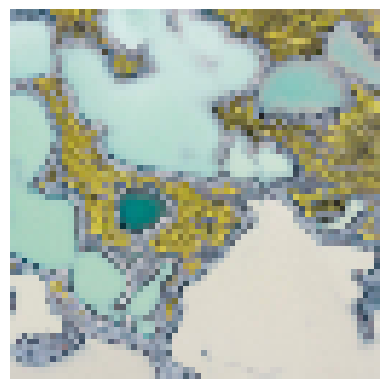

In [27]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

In [35]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),             #here is where the leakyRELU gets flattened then sent to final fully connected layer.
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 flatten_2 (Flatten)         (None, 8192)            

In [36]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        keras.layers.BatchNormalization(),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        keras.layers.BatchNormalization(),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape_3 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_9 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                                       
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_10 (Conv2D  (None, 32, 32, 256)      524544    
 Transpose)                                                      
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 32, 32, 256)       0 

In [37]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [38]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save(os.path.join(OUTPUT_DIR, "generated_img_%03d_%d.png" % (epoch, i)))


In [40]:
epochs = 500

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/500
18/18 [==============================] - 99s 5s/step - d_loss: 0.6614 - g_loss: 0.8123
Epoch 2/500
18/18 [==============================] - 103s 6s/step - d_loss: 0.6265 - g_loss: 0.8108
Epoch 3/500
18/18 [==============================] - 123s 7s/step - d_loss: 0.4307 - g_loss: 1.1913
Epoch 4/500
18/18 [==============================] - 116s 6s/step - d_loss: 0.3998 - g_loss: 1.8316
Epoch 5/500
18/18 [==============================] - 119s 6s/step - d_loss: 0.9977 - g_loss: 0.8494
Epoch 6/500
18/18 [==============================] - 119s 7s/step - d_loss: 0.7907 - g_loss: 0.8295
Epoch 7/500
18/18 [==============================] - 118s 6s/step - d_loss: 0.8087 - g_loss: 0.7718
Epoch 8/500
18/18 [==============================] - 120s 7s/step - d_loss: 0.3420 - g_loss: 1.8340
Epoch 9/500
18/18 [==============================] - 119s 7s/step - d_loss: 0.7758 - g_loss: 1.4610
Epoch 10/500
18/18 [==============================] - 121s 7s/step - d_loss: 0.5116 - g_loss: 1.3710


18/18 [==============================] - 128s 7s/step - d_loss: 0.3178 - g_loss: 2.5504
Epoch 83/500
18/18 [==============================] - 131s 7s/step - d_loss: 0.8568 - g_loss: 0.8106
Epoch 84/500
18/18 [==============================] - 130s 7s/step - d_loss: 0.4849 - g_loss: 1.4101
Epoch 85/500
18/18 [==============================] - 129s 7s/step - d_loss: 0.8757 - g_loss: 0.8658
Epoch 86/500
18/18 [==============================] - 128s 7s/step - d_loss: 0.7243 - g_loss: 0.9316
Epoch 87/500
18/18 [==============================] - 129s 7s/step - d_loss: 0.6425 - g_loss: 0.9372
Epoch 88/500
18/18 [==============================] - 128s 7s/step - d_loss: 0.4921 - g_loss: 1.1494
Epoch 89/500
18/18 [==============================] - 128s 7s/step - d_loss: 0.3771 - g_loss: 1.4654
Epoch 90/500
18/18 [==============================] - 128s 7s/step - d_loss: 0.6233 - g_loss: 1.2633
Epoch 91/500
18/18 [==============================] - 126s 7s/step - d_loss: 0.5574 - g_loss: 1.8277
Epo

18/18 [==============================] - 127s 7s/step - d_loss: 0.5594 - g_loss: 1.1047
Epoch 163/500
18/18 [==============================] - 131s 7s/step - d_loss: 0.5371 - g_loss: 1.1690
Epoch 164/500
18/18 [==============================] - 126s 7s/step - d_loss: 0.5631 - g_loss: 1.0272
Epoch 165/500
18/18 [==============================] - 130s 7s/step - d_loss: 0.5747 - g_loss: 1.0254
Epoch 166/500
18/18 [==============================] - 130s 7s/step - d_loss: 0.4752 - g_loss: 1.2041
Epoch 167/500
18/18 [==============================] - 130s 7s/step - d_loss: 0.4489 - g_loss: 1.2225
Epoch 168/500
18/18 [==============================] - 130s 7s/step - d_loss: 0.5224 - g_loss: 1.0823
Epoch 169/500
18/18 [==============================] - 130s 7s/step - d_loss: 0.6692 - g_loss: 0.8652
Epoch 170/500
18/18 [==============================] - 130s 7s/step - d_loss: 0.6677 - g_loss: 0.7770
Epoch 171/500
18/18 [==============================] - 130s 7s/step - d_loss: 0.5146 - g_loss: 1

18/18 [==============================] - 127s 7s/step - d_loss: 0.9036 - g_loss: 1.0607
Epoch 243/500
18/18 [==============================] - 127s 7s/step - d_loss: 0.3715 - g_loss: 1.5213
Epoch 244/500
18/18 [==============================] - 126s 7s/step - d_loss: 0.4694 - g_loss: 1.0873
Epoch 245/500
18/18 [==============================] - 128s 7s/step - d_loss: 0.7955 - g_loss: 0.8727
Epoch 246/500
18/18 [==============================] - 126s 7s/step - d_loss: 0.4474 - g_loss: 1.7920
Epoch 247/500
18/18 [==============================] - 126s 7s/step - d_loss: 0.4821 - g_loss: 1.5969
Epoch 248/500
18/18 [==============================] - 126s 7s/step - d_loss: 0.6834 - g_loss: 1.1556
Epoch 249/500
18/18 [==============================] - 128s 7s/step - d_loss: 0.5088 - g_loss: 1.2672
Epoch 250/500
18/18 [==============================] - 127s 7s/step - d_loss: 0.3090 - g_loss: 1.9861
Epoch 251/500
18/18 [==============================] - 127s 7s/step - d_loss: 0.2235 - g_loss: 2

18/18 [==============================] - 118s 6s/step - d_loss: 0.5430 - g_loss: 1.3980
Epoch 323/500
18/18 [==============================] - 119s 6s/step - d_loss: 0.5537 - g_loss: 1.2936
Epoch 324/500
18/18 [==============================] - 117s 6s/step - d_loss: 0.3860 - g_loss: 1.4406
Epoch 325/500
18/18 [==============================] - 119s 6s/step - d_loss: 0.5648 - g_loss: 1.3191
Epoch 326/500
18/18 [==============================] - 121s 7s/step - d_loss: 0.3102 - g_loss: 2.1821
Epoch 327/500
18/18 [==============================] - 122s 7s/step - d_loss: 0.5818 - g_loss: 1.6398
Epoch 328/500
18/18 [==============================] - 122s 7s/step - d_loss: 0.7140 - g_loss: 1.2335
Epoch 329/500
18/18 [==============================] - 121s 7s/step - d_loss: 0.5274 - g_loss: 1.6054
Epoch 330/500
18/18 [==============================] - 122s 7s/step - d_loss: 0.4007 - g_loss: 2.0515
Epoch 331/500
18/18 [==============================] - 120s 7s/step - d_loss: 0.4659 - g_loss: 1

18/18 [==============================] - 131s 7s/step - d_loss: 0.4350 - g_loss: 1.7277
Epoch 403/500
18/18 [==============================] - 129s 7s/step - d_loss: 0.5415 - g_loss: 1.4654
Epoch 404/500
18/18 [==============================] - 128s 7s/step - d_loss: 0.6311 - g_loss: 1.3200
Epoch 405/500
18/18 [==============================] - 130s 7s/step - d_loss: 0.5350 - g_loss: 1.4718
Epoch 406/500
18/18 [==============================] - 130s 7s/step - d_loss: 0.4710 - g_loss: 1.5501
Epoch 407/500
18/18 [==============================] - 126s 7s/step - d_loss: 0.4029 - g_loss: 1.4776
Epoch 408/500
18/18 [==============================] - 127s 7s/step - d_loss: 0.4788 - g_loss: 1.4525
Epoch 409/500
18/18 [==============================] - 129s 7s/step - d_loss: 0.7548 - g_loss: 1.0978
Epoch 410/500
18/18 [==============================] - 128s 7s/step - d_loss: 0.8492 - g_loss: 1.2435
Epoch 411/500
18/18 [==============================] - 127s 7s/step - d_loss: 0.7126 - g_loss: 1

18/18 [==============================] - 133s 7s/step - d_loss: 0.4170 - g_loss: 1.4534
Epoch 483/500
18/18 [==============================] - 131s 7s/step - d_loss: 0.4715 - g_loss: 1.6072
Epoch 484/500
18/18 [==============================] - 137s 8s/step - d_loss: 0.5653 - g_loss: 1.7060
Epoch 485/500
18/18 [==============================] - 132s 7s/step - d_loss: 0.8770 - g_loss: 1.3724
Epoch 486/500
18/18 [==============================] - 130s 7s/step - d_loss: 0.2126 - g_loss: 2.7074
Epoch 487/500
18/18 [==============================] - 131s 7s/step - d_loss: 0.4598 - g_loss: 1.5235
Epoch 488/500
18/18 [==============================] - 133s 7s/step - d_loss: 0.4963 - g_loss: 1.5860
Epoch 489/500
18/18 [==============================] - 129s 7s/step - d_loss: 0.6709 - g_loss: 1.3217
Epoch 490/500
18/18 [==============================] - 128s 7s/step - d_loss: 0.6700 - g_loss: 1.1936
Epoch 491/500
18/18 [==============================] - 129s 7s/step - d_loss: 0.6810 - g_loss: 1

### I will pick out some favourites of mine from those generated!

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\luoco\Miniconda3\envs\STEM\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['grid']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


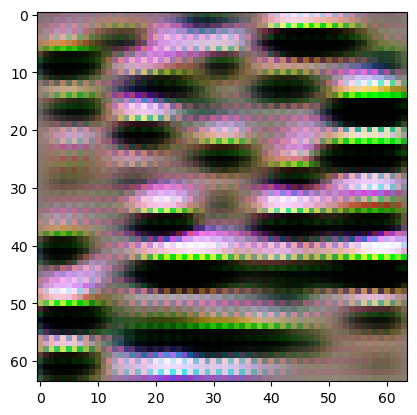

In [41]:
%pylab inline
import matplotlib.image as mpimg
img = mpimg.imread(r'C:\Users\luoco\Desktop\AI4M_assignment_1_dataset_versions\generated_img_220_9.png')
imgplot = plt.imshow(img)
plt.show()

^ Beginning to see lots of texture in this image. Almost like lots of boulders going on.

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


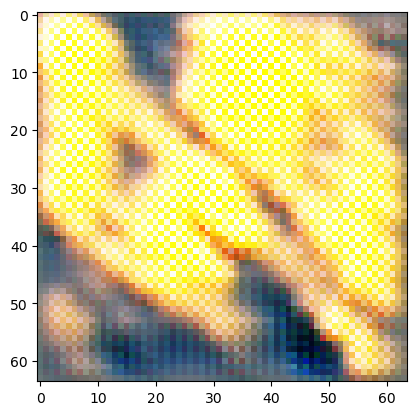

In [42]:
%pylab inline
import matplotlib.image as mpimg
img = mpimg.imread(r'C:\Users\luoco\Desktop\AI4M_assignment_1_dataset_versions\generated_img_320_3.png')
imgplot = plt.imshow(img)
plt.show()

^ The extremity of the yellow and the descent to orange/red at the edges is lovely.

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


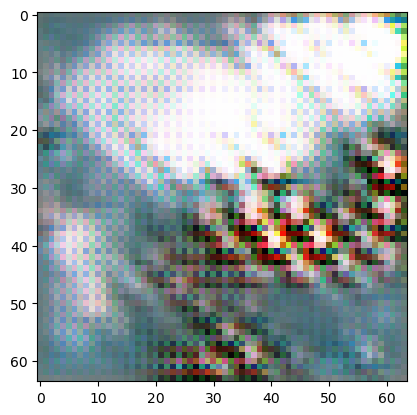

In [43]:
%pylab inline
import matplotlib.image as mpimg
img = mpimg.imread(r'C:\Users\luoco\Desktop\AI4M_assignment_1_dataset_versions\generated_img_330_0.png')
imgplot = plt.imshow(img)
plt.show()

^ This to me looks like some cloud coverage over some land. Some of these look more like real earth-like forms or display some sort of weather pattern.

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


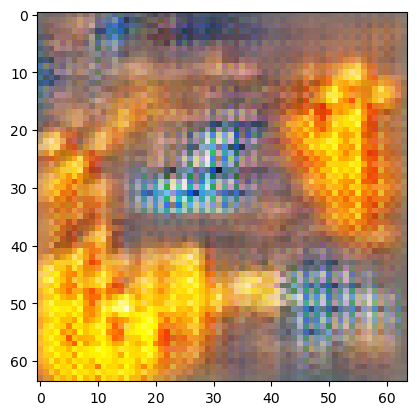

In [44]:
%pylab inline
import matplotlib.image as mpimg
img = mpimg.imread(r'C:\Users\luoco\Desktop\AI4M_assignment_1_dataset_versions\generated_img_494_0.png')
imgplot = plt.imshow(img)
plt.show()

^ and simiilarly here as well!

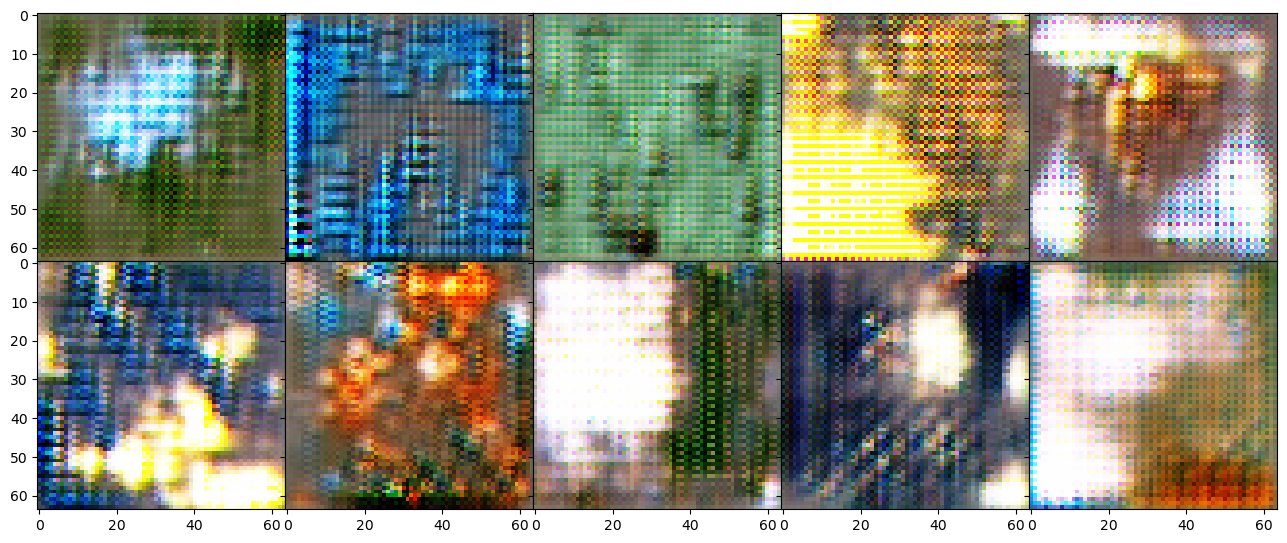

In [54]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(16., 16.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 5),  # creates 5x2 grid of axes
                 axes_pad=0,  # pad between axes in inch.
                 )

images = [f"C:/Users/luoco/Desktop/AI4M_assignment_1_dataset_versions/generated_img_4{x}{x}_{x}.png" for x in range(10)]

#using 4{x}{x}_{x}.png to show a portion of the later images generated

for ax, im in zip(grid, images):
    # Iterating over the grid returns the Axes.
    img = mpimg.imread(im)
    ax.imshow(img)

plt.show()


# Results
- Time: The longest run through of training was the 128*128 pixel image one which took around a 3 day period to complete the 100 epoch cycle of training. Having added Batch Normalization to the later runs, this most definitely enhanced the learning rate of the model (though I did set this back to 64*64 for efficiency and time). The final run of 500 epochs on the 64*64 pixel image generation with batch normalization took less than 2 days to complete the full epoch cycle of training. I was surprised how quickly this continued to run on my laptop with intriguing results.
- Results: The first few trials didn't have my hopes up for feasible generated outputs until, having done them, I purposely set the epochs a LOT higher knowing that it was very unlikely to overfit even at a low pixel resolution. The best results were from the final training cycle where it was a 64*64 image pixel output, 500 epochs with 2 batch normalization layers included in the network. This began to show me images in later epochs of images that looked like there was a seperation of land/sky/sea/hills, giving the images a true structure and form. Despite the low resolution to maximise my use of time, I really like the pixelated results!
- Earlier training did not have a good separation of multiple colours and lacked definition of any true content in the images.
- Batch Normormalization definitely produced better results from the effiency of training and the generated outputs themselves. This increases the depth and therefore capacity of the model. I could run this again in my ouwn time with the 128 resolution on thousands of epochs to get even better results. 